In [ ]:
!pip install snntorch
!pip install tonic


In [ ]:
import os
from typing import Callable, Optional
import numpy as np
import tonic
from tonic.dataset import Dataset
import tonic.transforms as transforms
import torch

class ToTensor:
    def __call__(self, array):
        return torch.from_numpy(array).float()


transform = transforms.Compose([
    transforms.ToFrame(sensor_size=(128, 128, 2), n_time_bins=16),
    ToTensor()
])

In [ ]:
import torch
from torch.utils.data import random_split

full_dataset = tonic.datasets.CIFAR10DVS(save_to='./content/data10', transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

trainset, testset = random_split(full_dataset, [train_size, test_size])

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(trainset)}")
print(f"Testing set size: {len(testset)}")

  0%|          | 0/11168490039 [00:00<?, ?it/s]

Extracting ./content/data10/CIFAR10DVS/CIFAR10DVS.zip to ./content/data10/CIFAR10DVS
Total dataset size: 10000
Training set size: 8000
Testing set size: 2000


In [ ]:
!pip install aedat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.2/496.2 kB 19.5 MB/s eta 0:00:00


In [ ]:
x, y = trainset[0]
print(type(x), x.shape, y)

<class 'torch.Tensor'> torch.Size([16, 2, 128, 128]) 1


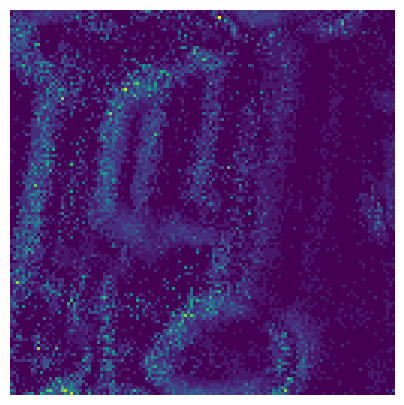

In [ ]:
from IPython.display import HTML  # <-- 1. Import HTML
import numpy as np
import tonic.utils as utils
frames = x.numpy()
frames = frames.sum(axis=1) # Changed axis from 0 to 1

animation = utils.plot_animation(frames=frames)

HTML(animation.to_html5_video())  # <-- 2. Convert to video and display

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import functional as SF
from snntorch import surrogate
from snntorch import backprop
from tqdm.auto import tqdm
from timm.models.layers import to_2tuple, trunc_normal_, DropPath
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from functools import partial
from timm.models import create_model

/tmp/ipython-input-3636983831.py:7: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [ ]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
a, b = next(iter(trainloader))
print(a.shape, b)

torch.Size([16, 16, 2, 128, 128]) tensor([9, 8, 9, 2, 8, 7, 4, 2, 1, 4, 1, 0, 6, 1, 0, 1])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [ ]:
class MultiStepLIFNode(nn.Module):
    def __init__(self, tau=2.0, v_threshold=1.0, v_reset=0.0,detach_reset=False) :
        super().__init__()
        beta = 1 - 1 / tau
        self.detach_reset = detach_reset
        self.lif = snn.Leaky(beta=beta,threshold=v_threshold,reset_mechanism="zero" if v_reset == 0 else "subtract")

    def forward(self,x):
      T,B=x.size(0),x.size(1)

      mem = self.lif.init_leaky()

      spk_out = []
      mem_out = []

      for t in range(T):
        spk, mem = self.lif(x[t], mem)


        # if self.detach_reset:
        #   mem_new = torch.where(spk.bool(), mem_new.detach(), mem_new)

        # mem=mem_new
        spk_out.append(spk)
        mem_out.append(mem)

      # Return only the spiking output, not the membrane potential
      return torch.stack(spk_out)

In [ ]:
# class QKTA(nn.module):
#   def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
#     super().__init__()
#     assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

#     self.dim = dim
#     self.num_heads = num_heads

#     self.q_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
#     self.k_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
#     self.q_bn=nn.BatchNorm1d(dim)
#     self.k_bn=nn.BatchNorm1d(dim)
#     self.q_lif=nn.MultiStepLIFNode(tau=2.0,detach_reset=True)
#     self.k_lif=nn.MultiStepLIFNode(tau=2.0,detach_reset=True)

#     self.At_lif=MultiStepLIFNode(tau=2.0, v_threshold=0.5, detach_reset=True)
#     self.proj_conv=nn.Conv1d(dim, dim, kernel_size=1, stride=1)
#     self.proj_bn=nn.BatchNorm1d(dim)
#     self.proj_lif=MultiStepLIFNode(tau=2.0, detach_reset=True)

#   def forward(self, x):
#     T,B,C,H,W=x.shape
#     x=x.flatten(3)
#     T,B,C,N=x.shape
#     x_qk=x.flatten(0, 1)

#     q1=self.q_conv(x_qk)
#     q1=self.q_bn(q1).reshape(T,B,C,N)
#     q1=self.q_lif(q1)
#     q=q1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)

#     k1=self.k_conv(x_qk)
#     k1=self.k_bn(k1).reshape(T,B,C,N)
#     k1=self.k_lif(k1)
#     k=k1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)

#     At=torch.sum(q,dim=3,keepdim=True)
#     At=self.At_lif(q)
#     x=torch.mul(At,k)

#     x=x.flatten(2,3)
#     x=self.proj_conv(x.flatten(0, 1))
#     x=self.proj_bn(x).reshape(T,B,C,H,W)
#     x=self.proj_lif(x)
#     return x






In [ ]:
# class QKCA(nn.module):
#   def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
#     super().__init__()
#     assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

#     self.dim = dim
#     self.num_heads = num_heads

#     self.q_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
#     self.k_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
#     self.q_bn=nn.BatchNorm1d(dim)
#     self.k_bn=nn.BatchNorm1d(dim)
#     self.q_lif=nn.MultiStepLIFNode(tau=2.0,detach_reset=True)
#     self.k_lif=nn.MultiStepLIFNode(tau=2.0,detach_reset=True)

#     self.Ac_lif=MultiStepLIFNode(tau=2.0, v_threshold=0.5, detach_reset=True)
#     self.proj_conv=nn.Conv1d(dim, dim, kernel_size=1, stride=1)
#     self.proj_bn=nn.BatchNorm1d(dim)
#     self.proj_lif=MultiStepLIFNode(tau=2.0, detach_reset=True)

#   def forward(self, x):
#     T,B,C,H,W=x.shape
#     x=x.flatten(3)
#     T,B,C,N=x.shape
#     x_qk=x.flatten(0, 1)

#     q1=self.q_conv(x_qk)
#     q1=self.q_bn(q1).reshape(T,B,C,N)
#     q1=self.q_lif(q1)
#     q=q1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)

#     k1=self.k_conv(x_qk)
#     k1=self.k_bn(k1).reshape(T,B,C,N)
#     k1=self.k_lif(k1)
#     k=k1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)

#     Ac=torch.sum(q,dim=4,keepdim=True)
#     Ac=self.Ac_lif(q)
#     x=torch.mul(Ac,k)

#     x=x.flatten(2,3)
#     x=self.proj_conv(x.flatten(0, 1))
#     x=self.proj_bn(x).reshape(T,B,C,H,W)
#     x=self.proj_lif(x)
#     return x

In [ ]:
class QKA(nn.Module):
  def __init__(self, dim,qc=1, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
    super().__init__()
    assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

    self.dim = dim
    self.num_heads = num_heads
    self.qc=qc
    self.q_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
    self.k_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
    self.q_bn=nn.BatchNorm1d(dim)
    self.k_bn=nn.BatchNorm1d(dim)
    self.q_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)
    self.k_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.At_lif=MultiStepLIFNode(tau=2.0, v_threshold=0.5, detach_reset=True)
    self.proj_conv=nn.Conv1d(dim, dim, kernel_size=1, stride=1)
    self.proj_bn=nn.BatchNorm1d(dim)
    self.proj_lif=MultiStepLIFNode(tau=2.0, detach_reset=True)

  def forward(self, x):
    T,B,C,H,W=x.shape
    x=x.flatten(3)
    T,B,C,N=x.shape
    x_qk=x.flatten(0, 1)

    q1=self.q_conv(x_qk)
    q1=self.q_bn(q1).reshape(T,B,C,N)
    q1=self.q_lif(q1)
    q=q1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)

    k1=self.k_conv(x_qk)
    k1=self.k_bn(k1).reshape(T,B,C,N)
    k1=self.k_lif(k1)
    k=k1.unsqueeze(2).reshape(T,B,self.num_heads,C//self.num_heads,N)
    if self.qc==1:
      At=torch.sum(q,dim=3,keepdim=True)
    else:
      At=torch.sum(q,dim=4,keepdim=True)
    At=self.At_lif(At)
    x=torch.mul(At,k)

    x=x.flatten(2,3)
    x=self.proj_conv(x.flatten(0, 1))
    x=self.proj_bn(x).reshape(T,B,C,H,W)
    x=self.proj_lif(x)
    return x




'''Mix class of QKTA(1) and QKCA(anything else), commented the above ones for now incase this somehow doesn't work'''

"Mix class of QKTA(1) and QKCA(anything else), commented the above ones for now incase this somehow doesn't work"

In [ ]:
class SPEDS1(nn.Module):
  def __init__(self,img_h=128,img_w=128,patch_size=4,in_channels=2,embed_dims=256):
    super().__init__()
    self.img_size=[img_h,img_w]
    patch_size=to_2tuple(patch_size)
    self.patch_size=patch_size
    self.H,self.W=img_h//patch_size[0],img_w//patch_size[1]
    self.C=in_channels
    self.num_patches=self.H*self.W
    self.embed_dims=embed_dims

    self.conv=nn.Conv2d(in_channels,embed_dims//8,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn=nn.BatchNorm2d(embed_dims//8)
    self.lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.conv1=nn.Conv2d(embed_dims//8,embed_dims//4,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(embed_dims//4)
    self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1,ceil_mode=False)
    self.lif1=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.conv2=nn.Conv2d(embed_dims//4,embed_dims//2,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2=nn.BatchNorm2d(embed_dims//2)
    self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1,ceil_mode=False)
    self.lif2=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.conv3=nn.Conv2d(embed_dims//2,embed_dims,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn3=nn.BatchNorm2d(embed_dims)
    self.maxpool3=nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1,ceil_mode=False)
    self.lif3=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.resconv=nn.Conv2d(embed_dims//4,embed_dims,kernel_size=1,stride=4,padding=0,bias=False)
    self.resbn=nn.BatchNorm2d(embed_dims)
    self.reslif=MultiStepLIFNode(tau=2.0,detach_reset=True)

  def forward(self,x):
    T,B,C,H,W=x.shape

    x=self.conv(x.flatten(0,1))
    x=self.bn(x).reshape(T,B,-1,H,W)
    x=self.lif(x).flatten(0,1).contiguous()

    x=self.conv1(x)
    x=self.bn1(x)
    x=self.maxpool1(x).reshape(T,B,-1,H//2,W//2).contiguous()
    x=self.lif1(x).flatten(0,1).contiguous()

    x_feat=x
    x=self.conv2(x)
    x=self.bn2(x)
    x=self.maxpool2(x).reshape(T,B,-1,H//4,W//4).contiguous()
    x=self.lif2(x).flatten(0,1).contiguous()

    x=self.conv3(x)
    x=self.bn3(x)
    x=self.maxpool3(x).reshape(T,B,-1,H//8,W//8).contiguous()
    x=self.lif3(x)

    x_feat=self.resconv(x_feat)
    x_feat=self.resbn(x_feat).reshape(T,B,-1,H//8,W//8).contiguous()
    x_feat=self.reslif(x_feat)
    x=x+x_feat

    return x

In [ ]:
class SPEDS2(nn.Module):
  def __init__(self,img_h=128,img_w=128,patch_size=4,in_channels=2,embed_dims=256):
    super().__init__()
    self.img_size=[img_h,img_w]
    patch_size=to_2tuple(patch_size)
    self.patch_size=patch_size
    self.H,self.W=img_h//patch_size[0],img_w//patch_size[1]
    self.C=in_channels
    self.num_patches=self.H*self.W
    self.embed_dims=embed_dims

    self.conv=nn.Conv2d(embed_dims//2,embed_dims,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn=nn.BatchNorm2d(embed_dims)
    self.lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.conv1=nn.Conv2d(embed_dims,embed_dims,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(embed_dims)
    self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1,dilation=1,ceil_mode=False)
    self.lif1=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.resconv=nn.Conv2d(embed_dims//2, embed_dims, kernel_size=1, stride=2, padding=0, bias=False)
    self.resbn=nn.BatchNorm2d(embed_dims)
    self.reslif=MultiStepLIFNode(tau=2.0, detach_reset=True)

  def forward(self,x):
    T,B,C,H,W=x.shape

    x=x.flatten(0,1).contiguous()
    x_feat=x

    x=self.conv(x)
    x=self.bn(x).reshape(T,B,-1,H,W)
    x=self.lif(x).flatten(0,1).contiguous()

    x=self.conv1(x)
    x=self.bn1(x)
    x=self.maxpool1(x).reshape(T,B,-1,H//2,W//2).contiguous()
    x=self.lif1(x)

    x_feat=self.resconv(x_feat)
    x_feat=self.resbn(x_feat).reshape(T,B,-1,H//2,W//2).contiguous()
    x_feat=self.reslif(x_feat)
    x=x+x_feat

    return x


In [ ]:
class SMLP(nn.Module):
  def __init__(self,in_features,hidden_features=None,out_features=None,drop=0.0):
    super().__init__()
    out_features=out_features if out_features is not None else in_features
    hidden_features=hidden_features if hidden_features is not None else in_features

    self.hidden=hidden_features
    self.output=out_features
    self.drop=drop

    self.c1=nn.Conv2d(in_features,hidden_features,kernel_size=1,stride=1)
    self.bn1=nn.BatchNorm2d(hidden_features)
    self.l1=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.c2=nn.Conv2d(hidden_features,out_features,kernel_size=1,stride=1)
    self.bn2=nn.BatchNorm2d(out_features)
    self.l2=MultiStepLIFNode(tau=2.0,detach_reset=True)

  def forward(self,x):
    T,B,C,H,W=x.shape

    x=self.c1(x.flatten(0,1))
    x=self.bn1(x).reshape(T,B,self.hidden,H,W)
    x=self.l1(x)

    x=self.c2(x.flatten(0,1))
    x=self.bn2(x).reshape(T,B,C,H,W)
    x=self.l2(x)
    return x

In [ ]:
class SSA(nn.Module):
  def __init__(self,dim,num_heads=8,scale=0.125,qkv_bias=False):
    super().__init__()
    assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
    self.dim=dim
    self.num_heads=num_heads
    head_dim=dim//num_heads
    self.scale=scale

    self.q_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
    self.k_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
    self.q_bn=nn.BatchNorm1d(dim)
    self.k_bn=nn.BatchNorm1d(dim)
    self.q_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)
    self.k_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.v_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=qkv_bias)
    self.v_bn=nn.BatchNorm1d(dim)
    self.v_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.proj_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1)
    self.proj_bn=nn.BatchNorm1d(dim)
    self.proj_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.attn_lif=MultiStepLIFNode(tau=2.0,v_threshold=0.5,detach_reset=True)

    self.qkv_mp=nn.MaxPool1d(4)

  def forward(self,x):

    T,B,C,H,W=x.shape
    x=x.flatten(3)
    T,B,C,N=x.shape
    x_qkv=x.flatten(0, 1)

    q1=self.q_conv(x_qkv)
    q1=self.q_bn(q1).reshape(T,B,C,N).contiguous()
    q1=self.q_lif(q1)
    q=q1.transpose(-1,-2).reshape(T,B,N,self.num_heads,C//self.num_heads).permute(0,1,3,2,4).contiguous()

    k1=self.k_conv(x_qkv)
    k1=self.k_bn(k1).reshape(T,B,C,N).contiguous()
    k1=self.k_lif(k1)
    k=k1.transpose(-1,-2).reshape(T,B,N,self.num_heads,C//self.num_heads).permute(0,1,3,2,4).contiguous()

    v1=self.v_conv(x_qkv)
    v1=self.v_bn(v1).reshape(T,B,C,N).contiguous()
    v1=self.v_lif(v1)
    v=v1.transpose(-1,-2).reshape(T,B,N,self.num_heads,C//self.num_heads).permute(0,1,3,2,4).contiguous()

    x=k.transpose(-2,-1)@v
    x=(q@x)*self.scale

    x=x.transpose(3,4).reshape(T,B,C,N).contiguous()
    x=self.attn_lif(x)

    # Fix: Flatten T and B for proj_conv, then reshape back before proj_lif
    x_for_proj_conv = x.flatten(0,1) # Shape (T*B, C, N)
    x_after_conv_bn = self.proj_bn(self.proj_conv(x_for_proj_conv)) # Shape (T*B, C, N)
    x = self.proj_lif(x_after_conv_bn.reshape(T,B,C,H,W)) # Reshape to (T, B, C, H, W) before LIF

    return x


In [ ]:
class SSSA(nn.Module):
  def __init__(self,dim,num_heads=8,T=16,v_threshold=1.0):
    super().__init__()
    assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
    self.dim=dim
    self.num_heads=num_heads
    head_dim=dim//num_heads
    self.T=T
    self.v_threshold=v_threshold
    Mw = torch.randn(T, T)
    self.Mw = nn.Parameter(torch.tril(Mw))
    self.q_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=False)
    self.k_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=False)
    self.q_bn=nn.BatchNorm1d(dim)
    self.k_bn=nn.BatchNorm1d(dim)
    self.q_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)
    self.k_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

    self.v_conv=nn.Conv1d(dim,dim,kernel_size=1,stride=1,bias=False)
    self.v_bn=nn.BatchNorm1d(dim)
    self.v_lif=MultiStepLIFNode(tau=2.0,detach_reset=True)

  def forward(self,x):
    T,B,C,H,W=x.shape
    x=x.flatten(3)
    T,B,C,N=x.shape
    x_qkv=x.flatten(0, 1)
    q1=self.q_conv(x_qkv)
    q1=self.q_bn(q1).reshape(T,B,C,N).contiguous()
    q1=self.q_lif(q1)
    q1 = q1.view(T, B, self.num_heads, C // self.num_heads, N)
    q = q1.sum(dim=3)

    k1=self.k_conv(x_qkv)
    k1=self.k_bn(k1).reshape(T,B,C,N).contiguous()
    k1=self.k_lif(k1)
    k1 = k1.view(T, B, self.num_heads, C // self.num_heads, N)
    k = k1.sum(dim=3)
    # k=k.transpose(-2,-1)
    q_=q.unsqueeze(-1)
    k_=k.unsqueeze(-2)
    croatt=q_*k_
    patch=croatt.sum(dim=2)
    patch = patch.sum(dim=-1)
    Ht=torch.einsum('ts,sbn->tbn',self.Mw,patch)
    v=self.v_lif(self.v_bn(self.v_conv(x_qkv)))
    v=v.reshape(T, B, C, N)
    S=(Ht>=self.v_threshold).float()
    #S=torch.sigmoid((Ht-self.v_threshold)*10), didn't perform well and takes more time
    sssa=v*S.unsqueeze(2)
    sssa=sssa.reshape(T,B,C,H,W)

    return sssa

In [ ]:
class TokenStage(nn.Module):
  def __init__(self,dim,num_heads,mlp_ratio=4.,drop=0.):
    super().__init__()
    self.tssa=QKA(qc=1,dim=dim,num_heads=num_heads)
    mlp_hidden_dim = int(dim * mlp_ratio)
    self.mlp=SMLP(in_features=dim,hidden_features=mlp_hidden_dim,drop=drop)

  def forward(self,x):
    x=x+self.tssa(x)
    x=x+self.mlp(x)

    return x

In [ ]:
class SpikingTransformer(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio=4.,drop=0.):
        super().__init__()
        self.ssa = SSA(dim, num_heads)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = SMLP(in_features= dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):

        x = x + self.ssa(x)
        x = x + self.mlp(x)

        return x

In [ ]:
class SaccadicTransformer(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio=4.,drop=0.):
        super().__init__()
        self.ssa = SSSA(dim, num_heads)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = SMLP(in_features= dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):

        x = x + self.ssa(x)
        x = x + self.mlp(x)

        return x

In [ ]:
class snn_vit(nn.Module):
  def __init__(self,img_size_h=128, img_size_w=128, patch_size=16, in_channels=2, num_classes=10,embed_dims_param=[64, 128, 256], num_heads=[1, 2, 4], mlp_ratios=[4, 4, 4], qkv_bias=False, qk_scale=None,drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,depths=[6, 8, 6], sr_ratios=[8, 4, 2], T=16, pretrained_cfg=None, in_chans = 3, no_weight_decay = None):
    super().__init__()
    self.num_classes=num_classes
    # Fix: Ensure depths is an integer for torch.linspace. Assuming total blocks is the sum if depths is a list.
    if isinstance(depths, list):
        total_depth = sum(depths)
    else:
        total_depth = depths
    self.depths=depths # Keep original for potential other uses if intended as list

    self.T=T
    # Hardcoded num_heads consistent with previous values (16,16,16)
    num_heads=[16,16,16]
    # Fix: Use total_depth for linspace steps
    dpr=[x.item() for x in torch.linspace(0,drop_path_rate,total_depth)]

    # Determine the actual embedding dimension used for subsequent layers
    if isinstance(embed_dims_param, int): # If QKFormer passes an int, use it directly
        self.output_embed_dim = embed_dims_param
    else: # Otherwise assume it's a list and use the last element (e.g., [64,128,256] -> 256)
        self.output_embed_dim = 256

    # For SPEDS1, use half of the final embedding dimension
    speds1=SPEDS1(patch_size=patch_size,embed_dims=self.output_embed_dim//2)
    stage1=TokenStage(dim=self.output_embed_dim//2,num_heads=16,mlp_ratio=4,drop=drop_rate)

    # For SPEDS2, use the full final embedding dimension
    speds2=SPEDS2(patch_size=patch_size,embed_dims=self.output_embed_dim)
    stage2=SaccadicTransformer(dim=self.output_embed_dim,num_heads=16,mlp_ratio=4,drop=drop_rate)

    setattr(self, f"patch_embed1", speds1)
    setattr(self, f"stage1", stage1)
    setattr(self, f"patch_embed2", speds2)
    setattr(self, f"stage2", stage2)

    self.head=nn.Linear(self.output_embed_dim,num_classes)
    self.apply(self._init_weights)

  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      nn.init.trunc_normal_(m.weight, std=.02)
      if isinstance(m, nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias, 0)


  def forward_features(self,x):
    stage1 = getattr(self, f"stage1")
    patch_embed1 = getattr(self, f"patch_embed1")
    stage2 = getattr(self, f"stage2")
    patch_embed2 = getattr(self, f"patch_embed2")

    x = patch_embed1(x)
    x=stage1(x)

    x = patch_embed2(x)
    x=stage2(x)
    return x.flatten(3).mean(3)


  def forward(self,x):
    x=x.permute(1,0,2,3,4)
    x=self.forward_features(x)
    x=self.head(x.mean(0))
    return x

In [ ]:
def QKFormer(pretrained=False, **kwargs):
    model = snn_vit(
        patch_size=16, num_heads=16, mlp_ratios=1,
        in_channels=2, num_classes=10, qkv_bias=False,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=4, sr_ratios=1,
        **kwargs
    )
    model.default_cfg = _cfg()
    return model


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SNNTorchMonitor:
    def __init__(self, model):
        self.hooks = []
        self.layer_names = []
        self.firing_rates = {}
        self.enable_monitor = False

        for name, layer in model.named_modules():
            if "MultiStepLIFNode" in str(type(layer)):
                self.layer_names.append(name)
                self.hooks.append(layer.register_forward_hook(self._hook_fn(name)))

    def _hook_fn(self, name):
        def hook(module, input, output):
            if self.enable_monitor:
                rate = output.float().mean().item()
                self.firing_rates[name] = rate
        return hook

    def enable(self):
        self.enable_monitor = True
        self.firing_rates = {}

    def disable(self):
        self.enable_monitor = False

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()

In [ ]:
from snntorch import spikeplot as splt
from snntorch import functional as SF
import torch.nn.functional as F


model=QKFormer().to(device)
criterion = nn.CrossEntropyLoss()
monitor = SNNTorchMonitor(model)
# optimizer=torch.optim.AdamW(model.parameters(),lr=5e-3,weight_decay=0.06,betas=(0.9,0.999),eps=1e-8)
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=0.06,betas=(0.9,0.999),eps=1e-8)
num_epochs=10

# Get num_classes from the model for one-hot encoding
num_classes = model.num_classes # Assuming model.num_classes is correctly set to 10

for epochs in range(num_epochs):
  model.train()
  running_loss=0.0
  correct = 0.0
  total = 0.0
  spike_rate=0.0
  for i, (inputs, labels) in enumerate(trainloader):
    inputs = inputs.to(device).float()
    labels = labels.to(device)

    if i == 0:
      monitor.enable()

    # Convert labels to one-hot encoding
    #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()

    optimizer.zero_grad()
    outputs=model(inputs)

    if i == 0:
      monitor.disable()

    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    spike_rate = inputs.mean().item()

    running_loss += loss.item()
    preds = outputs.argmax(dim=1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  print(f"\n--- Epoch {epochs} Health Check ---")
  if monitor.firing_rates:
    rates = list(monitor.firing_rates.values())
    avg_rate = sum(rates) / len(rates)
    min_rate = min(rates)
    max_rate = max(rates)

    print(f"Avg Firing Rate: {avg_rate*100:.2f}%")
    print(f"Min Firing Rate: {min_rate*100:.2f}% (Check for Dead Layers)")
    print(f"Max Firing Rate: {max_rate*100:.2f}% (Check for Epilepsy)")

    if min_rate == 0.0:
            print("⚠️ WARNING: At least one layer is SILENT (Dead Neurons)!")
  print("-----------------------------------")
  train_acc = correct / total
  print(f"Epoch {epochs}: Loss={(running_loss/len(trainloader)):.3f} TrainAcc={train_acc:.3f}")


--- Epoch 0 Health Check ---
Avg Firing Rate: 27.03%
Min Firing Rate: 8.13% (Check for Dead Layers)
Max Firing Rate: 74.85% (Check for Epilepsy)
-----------------------------------
Epoch 0: Loss=1.879 TrainAcc=0.288

--- Epoch 1 Health Check ---
Avg Firing Rate: 23.65%
Min Firing Rate: 8.05% (Check for Dead Layers)
Max Firing Rate: 54.76% (Check for Epilepsy)
-----------------------------------
Epoch 1: Loss=1.651 TrainAcc=0.398

--- Epoch 2 Health Check ---
Avg Firing Rate: 22.19%
Min Firing Rate: 6.43% (Check for Dead Layers)
Max Firing Rate: 50.17% (Check for Epilepsy)
-----------------------------------
Epoch 2: Loss=1.528 TrainAcc=0.447

--- Epoch 3 Health Check ---
Avg Firing Rate: 21.10%
Min Firing Rate: 6.80% (Check for Dead Layers)
Max Firing Rate: 45.75% (Check for Epilepsy)
-----------------------------------
Epoch 3: Loss=1.435 TrainAcc=0.491

--- Epoch 4 Health Check ---
Avg Firing Rate: 20.16%
Min Firing Rate: 7.03% (Check for Dead Layers)
Max Firing Rate: 46.61% (Check 

Test Accuracy: 0.5435 (1087/2000)


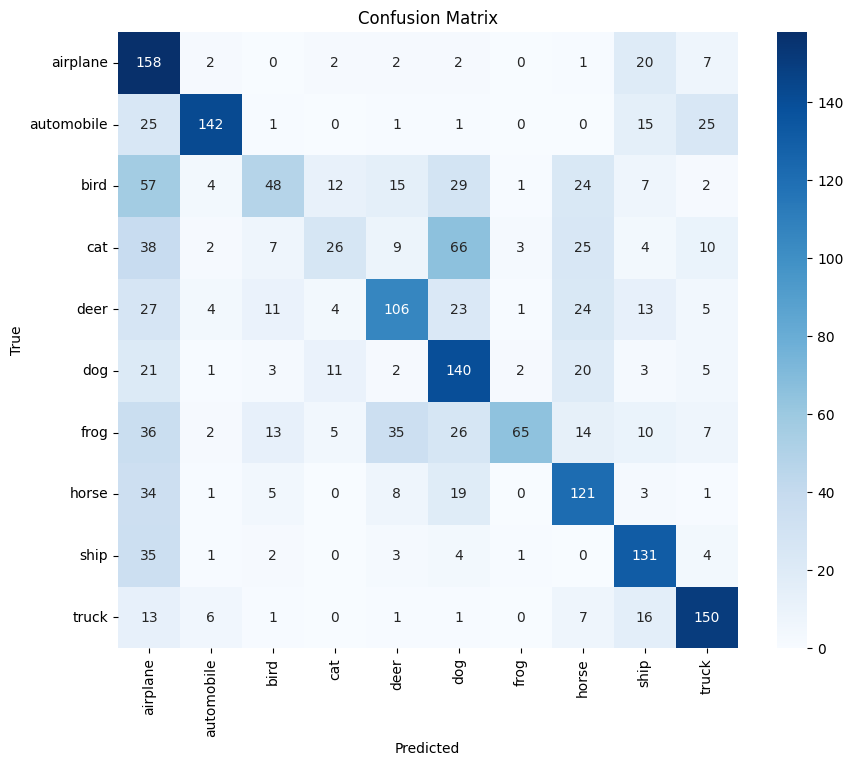

In [ ]:
#Evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
  for X,y in testloader:
    X=X.to(device).float()
    y=y.to(device)

    outputs=model(X)
    pred=outputs.argmax(dim=1)

    correct+=(pred==y).sum().item()
    total+=y.size(0)
    all_preds.extend(pred.cpu().numpy())
    all_targets.extend(y.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f} ({correct}/{total})")

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()